# 0. Imports

In [223]:
# Algebra and dataframes
import numpy as np
import pandas as pd

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# ROC
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Reading word2vec
import gensim

# XGBoost
import xgboost as xgb

# Chainer
import chainer
import chainer.links as L
import chainer.functions as F
import chainer.optimizers as O

# Misc
import os
import gc
import re
import math
from string import punctuation
import pickle
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
# Load the GoogleNews word2vec pretrained model (it takes some time)
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', binary=True)

# 1. Data Exploration

In [2]:
# Read the data
df_train = pd.read_csv('./data/train.csv')

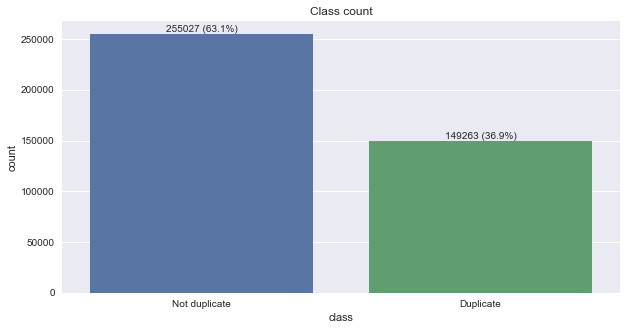

In [3]:
# Class distribution
plt.figure(figsize=(10, 5))
ax = sns.countplot(x = 'is_duplicate', data = df_train)
ax.set_title('Class count')
ax.set_xlabel('class')
ax.set_xticklabels(['Not duplicate','Duplicate'])
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('%d (%.1f%%)' % (y,y*100.0/df_train.shape[0]), (x.mean(), y), ha='center', va='bottom')

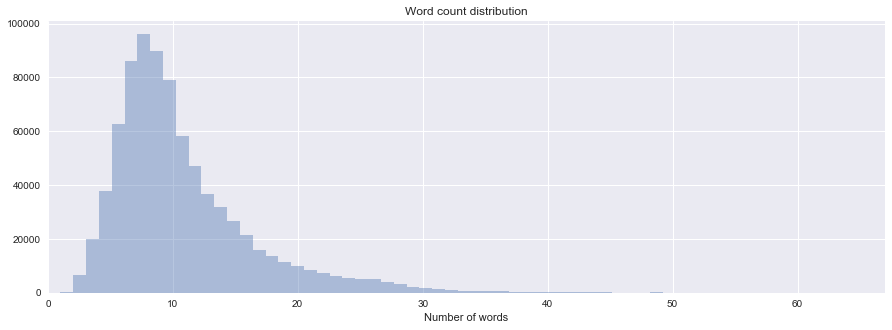

In [4]:
# Distribution of question length
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

train_len = train_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 5))
ax = sns.distplot(train_len, bins=230, kde=False)
ax.set_title('Sentence word count distribution')
ax.set_xlabel('Number of words')
ax.set_xlim([0, np.percentile(train_len.as_matrix(), 99.99)]);

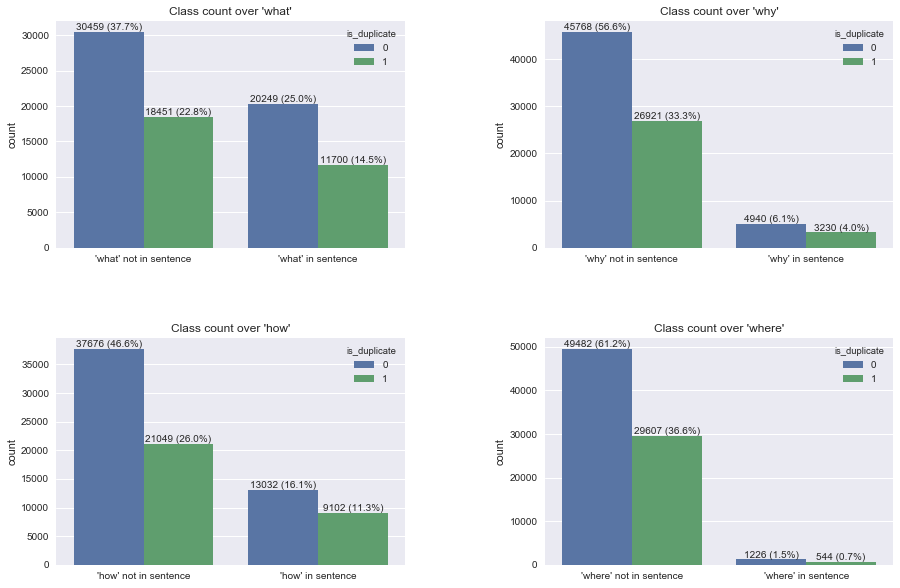

In [205]:
# Class distribution over different question starting words
question_starters = ['what','why','how','where']
f, axarr = plt.subplots(2, 2, figsize=(15,10))
f.subplots_adjust(hspace = 0.4, wspace = 0.4)

for (i,q) in enumerate(question_starters):
    col = train_qs.apply(lambda x: 1 if q in x.lower() else 0)
    
    sns.countplot(x = col, hue = df_train['is_duplicate'], ax = axarr[i/2,i%2] );
    axarr[i/2,i%2].set_title('Class count over \'%s\'' % q)
    axarr[i/2,i%2].set_xticklabels(['\'%s\' not in sentence' % q,'\'%s\' in sentence' % q])
    for p in axarr[i/2,i%2].patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        axarr[i/2,i%2].annotate('%d (%.1f%%)' % (y,y*100.0/df_train.shape[0]), (x.mean(), y), ha='center', va='bottom')

# 2. Data Preprocessing

In [6]:
# In this notebook, we will use only 20% of the data to work with to make calculations faster
df_train_old = df_train.copy()
df_train = df_train.loc[0:df_train.shape[0]*0.2]

## 2.1. De-Noising and Cleaning 

In [7]:
"""
Credit to Currie32@kaggle for this function:
https://www.kaggle.com/currie32/the-importance-of-cleaning-text
"""

# Clean the text, with the option to remove stop_words and to stem words.
def text_to_wordlist(text, remove_stop_words=True, stem_words=False):
    # Clean the text
    
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"switzerland", "Switzerland", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stopwords.words('english')]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [8]:
# Use the previously defined function to clean the text a bit
if(os.path.isfile('./custom_rows/question1_v')):
    df_train['question1_v'] = pd.read_pickle('./custom_rows/question1_v')
else:
    df_train['question1_v'] = pd.Series(df_train['question1'].apply(text_to_wordlist)).values
    df_train['question1_v'].to_pickle('./custom_rows/question1_v')
    
if(os.path.isfile('./custom_rows/question2_v')):
    df_train['question2_v'] = pd.read_pickle('./custom_rows/question2_v')
else:
    df_train['question2_v'] = pd.Series(df_train['question2'].apply(text_to_wordlist)).values
    df_train['question2_v'].to_pickle('./custom_rows/question2_v')

In [9]:
# Convert the string into lists of words with tokenize
if(os.path.isfile('./custom_rows/question1_v2')):
    df_train['question1_v2'] = pd.read_pickle('./custom_rows/question1_v2')
else:
    df_train['question1_v2'] = df_train['question1_v'].apply(nltk.word_tokenize)
    df_train['question1_v2'].to_pickle('./custom_rows/question1_v2')
    
if(os.path.isfile('./custom_rows/question2_v2')):
    df_train['question2_v2'] = pd.read_pickle('./custom_rows/question2_v2')
else:
    df_train['question2_v2'] = df_train['question2_v'].apply(nltk.word_tokenize)
    df_train['question2_v2'].to_pickle('./custom_rows/question2_v2')

In [10]:
# Calculate the frequency of each word over the whole corpus
if(os.path.isfile('./mydata/word_frequencies')):
    with open('./mydata/word_frequencies', 'rb') as handle:
        word_freq = pickle.load(handle)
else:
    word_freq = {'count':0, 'data':{}}
    for q in df_train['question1_v2'].append(df_train['question2_v2']):
        for word in q:
            if word in word_freq['data'].keys():
                word_freq['data'][word] += 1
            else:
                word_freq['data'][word] = 1
            word_freq['count'] += 1
            
    with open('./mydata/word_frequencies', 'wb') as handle:
        pickle.dump(word_freq, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# Tag the words in each sentence with the appropriate Part Of Speech tag
if(os.path.isfile('./custom_rows/question1_POS')):
    df_train['question1_POS'] = pd.read_pickle('./custom_rows/question1_POS')
else:
    df_train['question1_POS'] = df_train['question1_v2'].apply(nltk.pos_tag)
    df_train['question1_POS'].to_pickle('./custom_rows/question1_POS')
    
if(os.path.isfile('./custom_rows/question2_POS')):
    df_train['question2_POS'] = pd.read_pickle('./custom_rows/question2_POS')
else:
    df_train['question2_POS'] = df_train['question2_v2'].apply(nltk.pos_tag)
    df_train['question2_POS'].to_pickle('./custom_rows/question2_POS')

In [29]:
# Create the set of all words
word_set = set()
df_train['question1_v2'].apply(lambda x: [word_set.add(token) for token in x])
df_train['question2_v2'].apply(lambda x: [word_set.add(token) for token in x]);

word_indexes = {}
for i, word in enumerate(word_set):
    word_indexes[word.lower()] = i

In [12]:
# Create a word -> embedding translation matrix 
if(os.path.isfile('./mydata/embedding_matrix_v0.npy')):
    embedding_matrix = np.load('./mydata/embedding_matrix_v0.npy')
else:
    embedding_matrix = np.zeros((len(word_set), 300))
    for i, word in enumerate(word_set):
        if word in word2vec.vocab:
            embedding_matrix[i] = word2vec.word_vec(word)
        if word.lower() in word2vec.vocab:
            embedding_matrix[i] = word2vec.word_vec(word.lower())

    np.save('./mydata/embedding_matrix_v0.npy',embedding_matrix)
print('Words without an embedding vector: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 7846


## 2.2. Feature Crafting

In [14]:
# Function to calculate the absolute word count difference between 2 questions
def len_diff(row):
    return abs(len(row['question1_v2'])-len(row['question2_v2']))

In [15]:
# Function to calculate the distance between 2 questions' embeddings
def question_distance(row):
    if(len(row['question1_v2']) > 0 and len(row['question2_v2']) > 0):
        q1 = np.zeros((len(row['question1_v2']),300))
        for i in xrange(len(row['question1_v2'])):
            q1[i] = embedding_matrix[word_indexes[row['question1_v2'][i].lower()]]

        q2 = np.zeros((len(row['question2_v2']),300))
        for i in xrange(len(row['question2_v2'])):
            q2[i] = embedding_matrix[word_indexes[row['question2_v2'][i].lower()]]

        return sum(abs(q1.sum(0)/q1.shape[0] - q2.sum(0)/q2.shape[0]))
    return 1000

In [16]:
# Function to calculate the distance between 2 questions' embeddings, giving more weight to words that don't appear often
def question_distance_freq(row):
    if(len(row['question1_v2']) > 0 and len(row['question2_v2']) > 0):
        q1 = np.zeros((len(row['question1_v2']),300))
        for i in xrange(len(row['question1_v2'])):
            q1[i] = embedding_matrix[word_indexes[row['question1_v2'][i].lower()]] * (0.001/(0.001+word_freq['data'][row['question1_v2'][i]]))

        q2 = np.zeros((len(row['question2_v2']),300))
        for i in xrange(len(row['question2_v2'])):
            q2[i] = embedding_matrix[word_indexes[row['question2_v2'][i].lower()]] * (0.001/(0.001+word_freq['data'][row['question2_v2'][i]]))

        return sum(abs(q1.sum(0)/q1.shape[0] - q2.sum(0)/q2.shape[0]))
    return 1000

In [17]:
"""
Credit to anokas@kaggle for this function:
https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
"""

# Function to calculate the percentage of words that are shared between 2 questions
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1_v']).lower().split():
        q1words[word] = 1
    for word in str(row['question2_v']).lower().split():
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = float(len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [18]:
# Same as above, but checking that the POS tagging is also the same
def wordPOS_match_share(row):
    q1words = {}
    q2words = {}
    for word in row['question1_POS']:
        q1words['%s-%s' % (word[0].lower(),word[1])] = 1
    for word in row['question2_POS']:
        q2words['%s-%s' % (word[0].lower(),word[1])] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = float(len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [24]:
metrics = [{'name': 'Length difference', 'function': len_diff, 'color': 'darkorange', 'roc': lambda x: 1-x},
           {'name': 'Question distance', 'function': question_distance, 'color': 'green', 'roc': lambda x: 1/(x+0.0001)},
           {'name': 'Question distance (word frequency weighing)', 'function': question_distance_freq, 'color': 'blue', 'roc': lambda x: 1/(x+0.0001)},
           {'name': 'Shared words percentage', 'function': word_match_share, 'color': 'gray', 'roc': lambda x: x},
           {'name': 'Shared POS-words percentage', 'function': wordPOS_match_share, 'color': 'yellow', 'roc': lambda x: x}
          ]

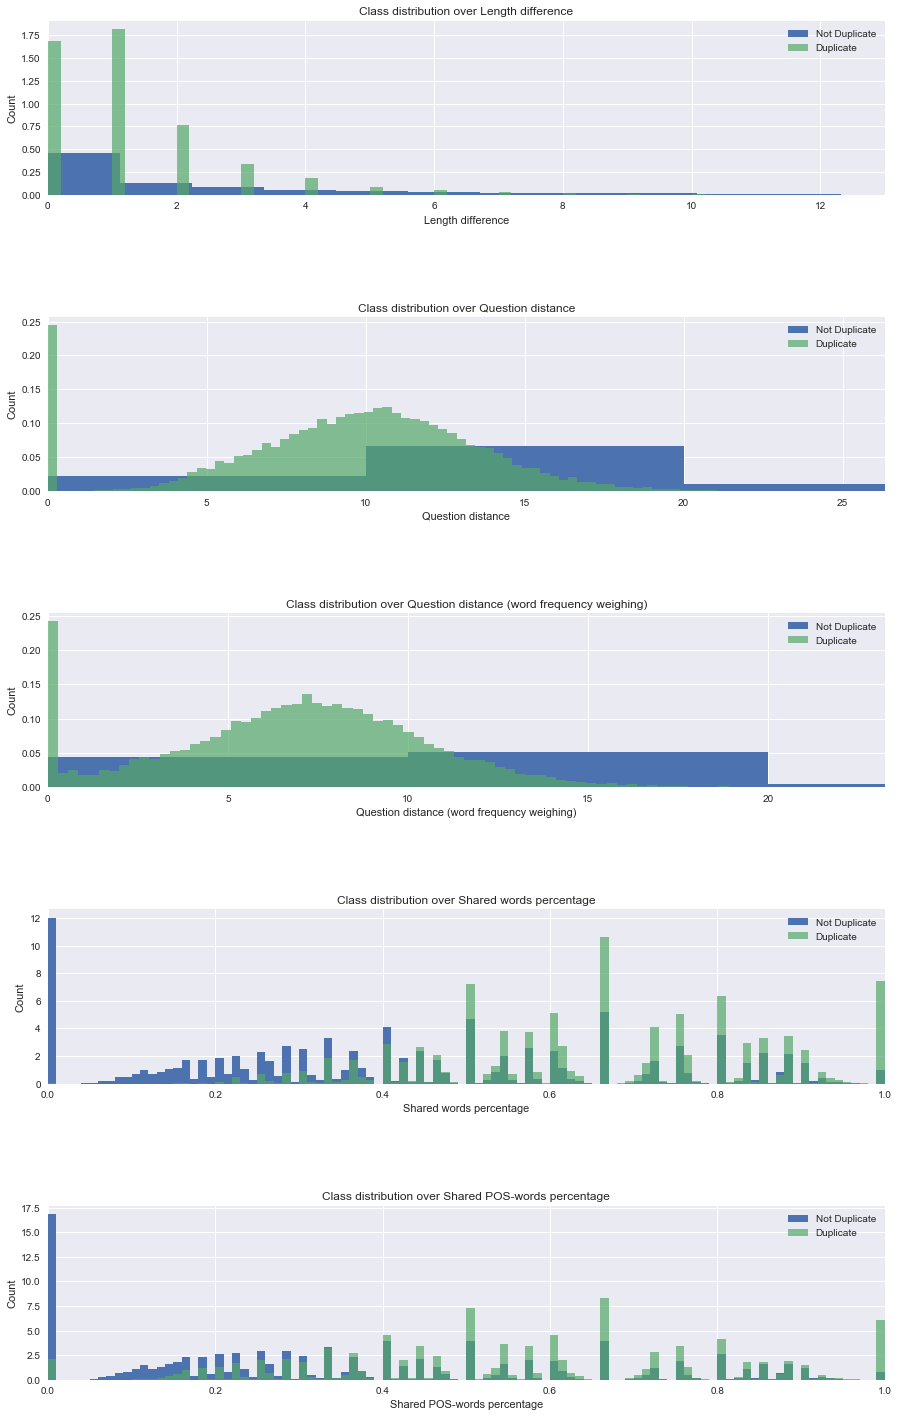

In [25]:
# Plot how each different feature helps to differentiate the classes
f, axarr = plt.subplots(len(metrics), figsize=(15,5*len(metrics)))
f.subplots_adjust(hspace = 0.7)
for i, metric in enumerate(metrics):
    if 'values' not in metric.keys():
        metric['values'] = df_train.apply(metric['function'],1)

    axarr[i].hist(metric['values'][df_train['is_duplicate'] == 0], bins=100, normed=True, label='Not Duplicate')
    axarr[i].hist(metric['values'][df_train['is_duplicate'] == 1], bins=100, normed=True, alpha=0.7, label='Duplicate')
    axarr[i].legend()
    axarr[i].set_xlim([0, np.percentile(metric['values'].as_matrix(), 99)])
    axarr[i].set_title('Class distribution over %s' % metric['name'])
    axarr[i].set_xlabel('%s' % metric['name']);
    axarr[i].set_ylabel('Count');

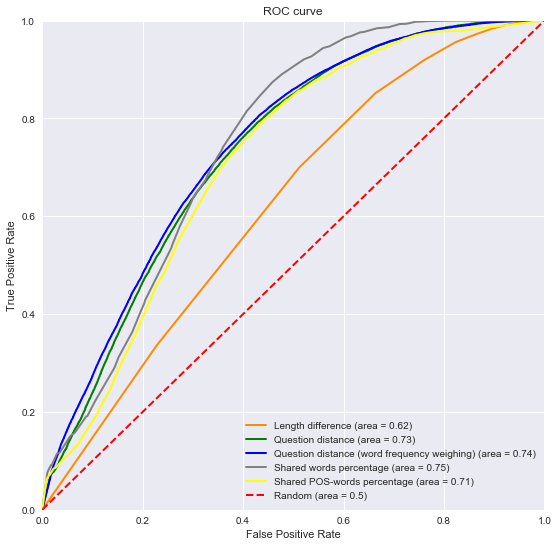

In [61]:
# AUC generated by each individual feature as discriminator
plt.figure(figsize=(9, 9))
lw = 2

for metric in metrics:
    fpr, tpr, th = roc_curve(df_train['is_duplicate'], metric['roc'](metric['values']))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=metric['color'], lw=lw, label='%s (area = %0.2f)' % (metric['name'],roc_auc))

plt.plot([0, 1], [0, 1], color='red', lw=lw, label='Random (area = 0.5)', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show();

# 3. Training 

## 3.1. XGBoost 

In [233]:
# Generate train and test sets
x_train = pd.DataFrame()
x_test = pd.DataFrame()
cutoff = int(df_train.shape[0]*0.8)

# Standardize the data columns
for i in xrange(len(metrics)):
    metrics[i]['values'] = preprocessing.scale(metrics[i]['values'])

x_train['len'] = metrics[0]['values'][0:cutoff]
x_train['dist'] = metrics[1]['values'][0:cutoff]
x_train['distf'] = metrics[2]['values'][0:cutoff]
x_train['common'] = metrics[3]['values'][0:cutoff]
x_train['commonPOS'] = metrics[4]['values'][0:cutoff]

x_test['len'] = metrics[0]['values'][cutoff:]
x_test['dist'] = metrics[1]['values'][cutoff:]
x_test['distf'] = metrics[2]['values'][cutoff:]
x_test['common'] = metrics[3]['values'][cutoff:]
x_test['commonPOS'] = metrics[4]['values'][cutoff:]

y_train = df_train['is_duplicate'][0:cutoff]
y_test = df_train['is_duplicate'][cutoff:]

x_train['len'].std()

0.9942363358338057

In [234]:
"""
Credit to anokas@kaggle for this code:
https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
"""

# Oversample the negative class
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

p = 0.165
scale = ((float(len(pos_train)) / (len(pos_train) + len(neg_train))) / float(p)) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

# Finally, we split some of the data off for validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [235]:
"""
Credit to anokas@kaggle for this code:
https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
"""

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.683028	valid-logloss:0.683278
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.600501	valid-logloss:0.602869
[20]	train-logloss:0.542013	valid-logloss:0.546333
[30]	train-logloss:0.499046	valid-logloss:0.505367
[40]	train-logloss:0.466609	valid-logloss:0.474862
[50]	train-logloss:0.441938	valid-logloss:0.451948
[60]	train-logloss:0.422694	valid-logloss:0.434486
[70]	train-logloss:0.407897	valid-logloss:0.421121
[80]	train-logloss:0.396301	valid-logloss:0.410796
[90]	train-logloss:0.387179	valid-logloss:0.402877
[100]	train-logloss:0.379712	valid-logloss:0.396658
[110]	train-logloss:0.37349	valid-logloss:0.391754
[120]	train-logloss:0.36826	valid-logloss:0.387808
[130]	train-logloss:0.363702	valid-logloss:0.384637
[140]	train-logloss:0.360013	valid-logloss:0.382201
[150]	train-logloss:0.356796	valid-logloss:0.380191
[160]	train-logloss:0.354235	v

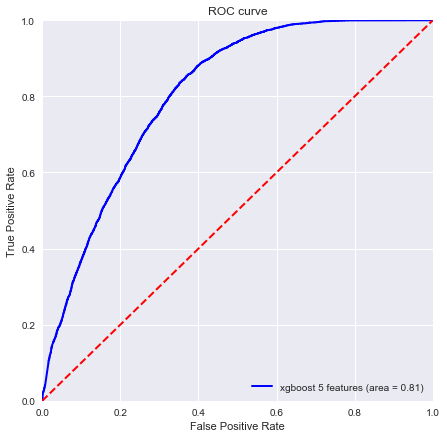

In [236]:
# Plot AUC for the test set
plt.figure(figsize=(7, 7))
lw = 2

fpr, tpr, th = roc_curve(y_test, bst.predict(d_test))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=lw, label='xgboost 5 features (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show();

In [286]:
tr_pred = np.array(bst.predict(d_train))
val_pred = np.array(bst.predict(d_valid))
tr_truth = np.array(y_train)
val_truth = np.array(y_valid)
best = -1
best_rates = (0,0,0,0)

for i in xrange(0,len(th),25):
    threshold = th[i]
    tr_pred_aux = tr_pred.copy()
    val_pred_aux = val_pred.copy()
    tr_pred_aux[np.where(tr_pred_aux > threshold)[0]] = 1
    tr_pred_aux[np.where(tr_pred_aux <= threshold)[0]] = 0
    val_pred_aux[np.where(val_pred_aux > threshold)[0]] = 1
    val_pred_aux[np.where(val_pred_aux <= threshold)[0]] = 0
    
    tp = sum( np.logical_and(tr_pred_aux == y_train, tr_truth == 1))
    tn = sum( np.logical_and(tr_pred_aux == y_train, tr_truth == 0))
    fp = sum( np.logical_and(tr_pred_aux != y_train, tr_truth == 0))
    fn = sum( np.logical_and(tr_pred_aux != y_train, tr_truth == 1))
    
    tpr = float(tp)/(tp+fn)
    tnr = float(tn)/(fp+tn)
    
    if(tpr+tnr > best):
        best = tpr+tnr
        best_rates = (tp,tn,fp,fn)

print('Average accuracy: %.4f' % (best/2))
print('True positives: %d, False negatives: %d' % (best_rates[0], best_rates[3]))
print('True negatives: %d, False positives: %d' % (best_rates[1], best_rates[2]))

Average accuracy: 0.8277
True positives: 16359, False negatives: 2959
True negatives: 66157, False positives: 15656


<h1>Confusion matrix</h1>
<table style="text-align: center">
    <tr>
        <td></td>
        <td></td>
        <td style="font-weight: bold" colspan="2">Real</td>
    </tr>
    <tr>
        <td colspan="2"></td>
        <td>0</td>
        <td>1</td>
    </tr>
    <tr>
        <th style="font-weight: bold" rowspan="2">Predicted</th>
        <td>0</td>
        <td>66157</td>
        <td>2959</td>
    </tr>
    <tr>
        <td>1</td>
        <td>15656</td>
        <td>16359</td>
    </tr>
</table>

## 3.2. Neural Net

In [222]:
# Function to transform a list of words into a sentence embedding
def sentence_embedding(sentence):
    if(len(sentence) > 0):
        embeddings = np.zeros((len(sentence),300))
        for i in xrange(len(sentence)):
            embeddings[i] = embedding_matrix[word_indexes[sentence[i].lower()]]

        return embeddings.sum(0)/embeddings.shape[0]
    else:
        return 1000

In [252]:
# Function to standardize rows
def my_scale(row):
    return np.append(preprocessing.scale(row[0:300]),preprocessing.scale(row[300:]))

In [96]:
# Create data with all the sentences transformed into embeddings
data = np.zeros((df_train.shape[0], 600), dtype=np.float32)
data = np.apply_along_axis(my_scale,1,data)
labels = np.zeros(df_train.shape[0])
for row in xrange(df_train.shape[0]):
    data[row][0:300] = sentence_embedding(df_train['question1_v2'].loc[row])
    data[row][300:600] = sentence_embedding(df_train['question2_v2'].loc[row])
    labels[row] = df_train['is_duplicate'].loc[row]

In [103]:
# Split training and validation data
permutation = np.random.permutation(data.shape[0])
training_perc = 0.8
cutoff = int(training_perc*data.shape[0])

tr_data = data[permutation[0:cutoff]]
val_data = data[permutation[cutoff:]]
tr_labels = labels[permutation[0:cutoff]]
val_labels = labels[permutation[cutoff:]]

<h1>Network 1 Scheme:</h1>
<img src="img/quora_simple_network.png" style="width:30%; height: auto">

In [201]:
# Network definition
class QuoraSimpleNN(chainer.Chain):

    def __init__(self):
        w = math.sqrt(2)
        super(QuoraSimpleNN, self).__init__(
            l1 = L.Linear(600,300),
            l2 = L.Linear(300,150),
            l3 = L.Linear(150,2),
            bn1 = L.BatchNormalization(600),
            bn2 = L.BatchNormalization(125),
            lstm = L.LSTM(300, 300)
        )

    def __call__(self, row):
        h = F.relu(self.l1(row))
        h = F.dropout(h, 0.5)
        
        h = F.relu(self.l2(h))
        h = F.dropout(h, 0.5)
        
        h = F.softmax(F.relu(self.l3(h)))

        return h


model = QuoraSimpleNN()

In [202]:
# Set up the optimizer (using Adam)
optimizer = O.Adam(beta1=0.9, beta2=0.9)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(0.0001))

In [203]:
# Training loop
tr_size = int(tr_data.shape[0]*1)
val_size = int(val_data.shape[0]*1)
batch_size = 64
tr_nbatches = tr_size//batch_size
tr_last_batch = tr_size%batch_size
val_nbatches = val_size//batch_size
val_last_batch = val_size%batch_size

chainer.using_config('train', True)

for epoch in xrange(100):
    tr_loss = 0
    for batch in xrange(tr_nbatches):
        tr_res = model(tr_data[batch:batch+batch_size])
        if(type(loss) == int):
            tr_loss = F.loss.softmax_cross_entropy.softmax_cross_entropy(tr_res, tr_labels[batch:batch+batch_size].astype(np.int32))
        else:
            tr_loss += F.loss.softmax_cross_entropy.softmax_cross_entropy(tr_res, tr_labels[batch:batch+batch_size].astype(np.int32))
    
    if(tr_last_batch > 0):
        tr_res = model(tr_data[-tr_last_batch:])
        if(type(loss) == int):
            tr_loss = F.loss.softmax_cross_entropy.softmax_cross_entropy(tr_res, tr_labels[-tr_last_batch:].astype(np.int32))
        else:
            tr_loss += F.loss.softmax_cross_entropy.softmax_cross_entropy(tr_res, tr_labels[-tr_last_batch:].astype(np.int32))      
    
    tr_loss = tr_loss/(tr_nbatches + 1 if tr_last_batch > 0 else 0)

    
    val_loss = 0
    for batch in xrange(val_nbatches):
        val_res = model(val_data[batch:batch+batch_size])
        if(type(loss) == int):
            val_loss = F.loss.softmax_cross_entropy.softmax_cross_entropy(val_res, val_labels[batch:batch+batch_size].astype(np.int32))
        else:
            val_loss += F.loss.softmax_cross_entropy.softmax_cross_entropy(val_res, val_labels[batch:batch+batch_size].astype(np.int32))
    
    if(val_last_batch > 0):
        val_res = model(val_data[-val_last_batch:])
        if(type(loss) == int):
            val_loss = F.loss.softmax_cross_entropy.softmax_cross_entropy(val_res, val_labels[-val_last_batch:].astype(np.int32))
        else:
            val_loss += F.loss.softmax_cross_entropy.softmax_cross_entropy(val_res, val_labels[-val_last_batch:].astype(np.int32))
    
    val_loss = val_loss/(val_nbatches + 1 if val_last_batch > 0 else 0)
    
    print('Epoch %3d - Training loss: %.6f - Test loss: %.6f' % (epoch, tr_loss.data, val_loss.data))
    
    # Update step
    model.zerograds()
    tr_loss.backward()
    optimizer.update()

chainer.using_config('train', False)

Epoch   0 - Training loss: 0.691908 - Test loss: 0.692123
Epoch   1 - Training loss: 0.684416 - Test loss: 0.685400
Epoch   2 - Training loss: 0.675511 - Test loss: 0.677079
Epoch   3 - Training loss: 0.666596 - Test loss: 0.668774
Epoch   4 - Training loss: 0.658387 - Test loss: 0.661407
Epoch   5 - Training loss: 0.651622 - Test loss: 0.655848
Epoch   6 - Training loss: 0.646897 - Test loss: 0.651723
Epoch   7 - Training loss: 0.644200 - Test loss: 0.648958
Epoch   8 - Training loss: 0.643353 - Test loss: 0.648526
Epoch   9 - Training loss: 0.642938 - Test loss: 0.648142
Epoch  10 - Training loss: 0.643255 - Test loss: 0.649392
Epoch  11 - Training loss: 0.643147 - Test loss: 0.648994
Epoch  12 - Training loss: 0.642773 - Test loss: 0.649533
Epoch  13 - Training loss: 0.642036 - Test loss: 0.648195
Epoch  14 - Training loss: 0.640632 - Test loss: 0.647981
Epoch  15 - Training loss: 0.638656 - Test loss: 0.646380
Epoch  16 - Training loss: 0.636207 - Test loss: 0.644468
Epoch  17 - Tr

<h1>Network 2 Scheme:</h1>
<img src="img/quora_lstm_network.png" style="width:30%; height: auto">

In [39]:
# Network definition
class QuoraLstmNN(chainer.Chain):

    def __init__(self):
        w = math.sqrt(2)
        super(QuoraLstmNN, self).__init__(
            l1 = L.Linear(600,125),
            l2 = L.Linear(125,2),
            bn1 = L.BatchNormalization(600),
            bn2 = L.BatchNormalization(125),
            lstm = L.LSTM(300, 300)
        )

    def __call__(self, row):
        #for sentence1, sentence2 in (row):
        self.lstm.reset_state()
        h1 = np.zeros((1,300), dtype=np.float32)
        for word in row['question1_v2']:
            h1 = self.lstm(np.reshape(embedding_matrix[word_indexes[word.lower()]],(1,300)).astype(np.float32))
         
        h2 = np.zeros((1,300), dtype=np.float32)
        self.lstm.reset_state()
        for word in row['question2_v2']:
            h2 = self.lstm(np.reshape(embedding_matrix[word_indexes[word.lower()]],(1,300)).astype(np.float32))

        h = F.concat((h1,h2))
        h = F.dropout(h, 0.3)
        #h = self.bn1(h)
        
        h = F.relu(self.l1(h))
        h = F.dropout(h, 0.3)
        #h = self.bn2(h)
        
        h = F.softmax(F.relu(self.l2(h)))

        return h


model = QuoraLstmNN()

In [110]:
# Set up the optimizer (Adam)
optimizer = O.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(0.0001))

In [41]:
# Training loop
tr_size = int(df_train.shape[0]*0.005)
tr_d = int(df_train.shape[0]*0.005)

chainer.using_config('train', True)

for i in xrange(100):
    loss = 0
    for b in xrange(tr_size):
        r = model(df_train.loc[b])
        if(type(loss) == int):
            loss = F.loss.softmax_cross_entropy.softmax_cross_entropy(r, np.array([df_train['is_duplicate'].loc[b]], dtype=np.int32))
        else:
            loss += F.loss.softmax_cross_entropy.softmax_cross_entropy(r, np.array([df_train['is_duplicate'].loc[b]], dtype=np.int32))
    
    loss = loss/b
    
    chainer.using_config('train', False)
    loss2 = 0
    for b in xrange(tr_size,tr_size+tr_d):
        r2 = model(df_train.loc[b])
        if(type(loss2) == int):
            loss2 = F.loss.softmax_cross_entropy.softmax_cross_entropy(r2, np.array([df_train['is_duplicate'].loc[b]], dtype=np.int32))
        else:
            loss2 += F.loss.softmax_cross_entropy.softmax_cross_entropy(r2, np.array([df_train['is_duplicate'].loc[b]], dtype=np.int32))
    loss2 = loss2/(b-tr_size)
    chainer.using_config('train', True)
    
    print('%.6f - %.6f' % (loss.data, loss2.data))
    
    # Update step
    model.zerograds()
    loss.backward()
    optimizer.update()

chainer.using_config('train', False)

404
0.696628 - 0.696370
0.690159 - 0.691735
0.680912 - 0.681981
0.668717 - 0.672310
0.655393 - 0.658877
0.651730 - 0.650217
0.650501 - 0.651921
0.652120 - 0.650099
0.648158 - 0.648363
0.641999 - 0.647802
0.630982 - 0.641945
0.625320 - 0.640152
0.623444 - 0.643820
0.620490 - 0.644423
0.610645 - 0.637651
0.601426 - 0.631963
0.596266 - 0.632548
0.591811 - 0.633366
0.581782 - 0.635961
0.574793 - 0.634659
0.566521 - 0.638185
0.552328 - 0.631969
0.542641 - 0.634125


KeyboardInterrupt: 